### Building chatbot with multiple tools

#### AIM
Create a chatbot with tool capabilities from arxiv,wikipedia search and some functions

In [1]:
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun

from langchain_community.utilities import ArxivAPIWrapper,WikipediaAPIWrapper


In [2]:
api_wrapper_arxiv = ArxivAPIWrapper(top_k_results=2,doc_content_char_max=500)
arxiv = ArxivQueryRun(api_wrapper=api_wrapper_arxiv)
print(arxiv.name)

arxiv


In [3]:
arxiv.invoke("Attention is all you need")

"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models\nAuthors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini\nSummary: The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with low latencies remains challenging due to the quadratic input length\ncomplexity of the attention layers. In this work, we investigate the effect of\ndropping MLP and attention layers at inference time on the performance of\nLlama-v2 models. We find that dropping dreeper attention layers only marginally\ndecreases performance but leads to the best speedups alongside dropping entire\nlayers. For example, removing 33\\% of attention layers in a 13B Llama2 model\nresults in a 1.8\\% drop in average performance over the OpenLLM benchmark. We\nalso observe that skipping layers except the latter layers reduces performances\nfor more layers skipped, except for skipping the attention layers.\n\n

In [4]:
api_wrapper_wikipedia = WikipediaAPIWrapper(top_k_results=2, doc_content_chars_max=500)
wikipedia = WikipediaQueryRun(api_wrapper=api_wrapper_wikipedia)
print(wikipedia.name)

wikipedia


In [5]:
wikipedia.invoke("What is machine learning")

'Page: Machine learning\nSummary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalise to unseen data, and thus perform tasks without explicit instructions. Within a subdiscipline in machine learning, advances in the field of deep learning have allowed neural networks, a class of statistical algorithms, to surpass many previous machine learning approaches in performance.\nML fi'

In [6]:
from dotenv import load_dotenv
load_dotenv
import os
os.environ["TAVILY_API_KEY"]=os.getenv("TAVILY_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")

In [7]:
### Tavily Search
from langchain_community.tools.tavily_search import TavilySearchResults
tavily=TavilySearchResults()

C:\Users\bhatt\AppData\Local\Temp\ipykernel_30812\2019592739.py:3: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  tavily=TavilySearchResults()


In [9]:
tavily.invoke("Provide me recent AI news for November")

[{'title': 'AI News November 8 2025: 24 Breaking OpenAI & Gemini Updates',
  'url': 'https://binaryverseai.com/ai-news-november-8-2025/',
  'content': 'Early adopters report high-throughput use cases that combine results in under two seconds, replacing patchwork chunkers, vector DBs, and re-rankers. For AI News November 8 2025, the signal is clear. Retrieval is becoming a commodity feature with verification by default, which raises the bar for support bots, internal assistants, and research agents. This is one of the top AI news stories if you value grounded output over clever phrasing.\n\nGemini 2.5 Pro vs Gemini Deep Research [...] The partnership also targets “agentification” with reusable, domain-specific agents that follow explicit policies and approvals. Financial services gets the initial industry patterns, with responsible AI practices treated as first-class requirements. This belongs in AI news this week November 2025 because it shows what scaled adoption looks like: capabilit

In [10]:
### combile all the tools in the list
tools = [arxiv, wikipedia,tavily]


In [12]:
## Initialisze the llm model

from langchain_groq import ChatGroq
llm = ChatGroq(model="qwen/qwen3-32b")

#bind
llm_with_tools = llm.bind_tools(tools)

In [14]:
from pprint import pprint
from langchain_core.messages import HumanMessage, AIMessage

llm_with_tools.invoke([HumanMessage(content="what is the recent AI news")]).tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'recent AI news'},
  'id': '6ryzfs5ty',
  'type': 'tool_call'}]

In [15]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages
from typing import Annotated

class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

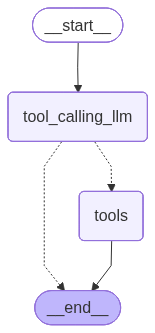

In [17]:
## Entire chatbot wit LAnggraph
from IPython.display import Image,display
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode,tools_condition

## Node defination

def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

## build graph

builder=StateGraph(State)

## Add nodes
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

## Add edges
builder.add_edge(START, "tool_calling_llm")

builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tool_condition routes to tool
    # If the latest message (result) from assistant is not a tool call -> tools_condition routes to tools
    
    tools_condition
)

builder.add_edge("tools", END)

graph_builder=builder.compile()
display(Image(graph_builder.get_graph().draw_mermaid_png()))


In [18]:
messages = graph_builder.invoke({
    "messages": HumanMessage(content="What is attention is all you need")
})

for message in messages["messages"]:
    message.pretty_print()  

================================ Human Message =================================

What is attention is all you need
================================== Ai Message ==================================
Tool Calls:
  arxiv (7g5pfah2s)
 Call ID: 7g5pfah2s
  Args:
    query: Attention Is All You Need
================================= Tool Message =================================
Name: arxiv

Published: 2024-07-22
Title: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models
Authors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini
Summary: The inference demand for LLMs has skyrocketed in recent months, and serving
models with low latencies remains challenging due to the quadratic input length
complexity of the attention layers. In this work, we investigate the effect of
dropping MLP and attention layers at inference time on the performance of
Llama-v2 models. We find that dropping dreeper attention layers only marginally
decreases p

In [19]:
messages = graph_builder.invoke({
    "messages": HumanMessage(content="Provide me Top recent AI news from March 2025")
})

for message in messages["messages"]:
    message.pretty_print()  

================================ Human Message =================================

Provide me Top recent AI news from March 2025
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (ec9csgxqq)
 Call ID: ec9csgxqq
  Args:
    query: Top AI news March 2025
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "Top 5 AI trends in March 2025: AI agents, smarter supply chains ...", "url": "https://www.neudesic.com/blog/top-5-ai-trends-march-2025/", "content": "March 2025 has brought a fresh wave of AI innovations that go beyond theoretical breakthroughs and translate directly into real-world impact. From OpenAI’s newly released tools for building AI agents to Microsoft’s external knowledge integration approach, this month’s highlights underscore how artificial intelligence is evolving in ways that matter today, not just tomorrow. Whether it’s optimizin

In [20]:
messages = graph_builder.invoke({
    "messages": HumanMessage(content="What is machine learning")
})

for message in messages["messages"]:
    message.pretty_print()  

================================ Human Message =================================

What is machine learning
================================== Ai Message ==================================
Tool Calls:
  wikipedia (6dywbfxt3)
 Call ID: 6dywbfxt3
  Args:
    query: machine learning
================================= Tool Message =================================
Name: wikipedia

Page: Machine learning
Summary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalise to unseen data, and thus perform tasks without explicit instructions. Within a subdiscipline in machine learning, advances in the field of deep learning have allowed neural networks, a class of statistical algorithms, to surpass many previous machine learning approaches in performance.
ML fi
